In [1]:
import mechwolf as mw
from datetime import timedelta

In [3]:
# Harvard pump code
import time
import asyncio
from loguru import logger
from mechwolf import _ureg

class HarvardSyringePump(mw.Pump):
    def __init__(self, syringe_volume, syringe_diameter, serial_port, name = None):
        super().__init__(name = name)
        self.serial_port = serial_port
        self.syringe_volume = _ureg.parse_expression(syringe_volume)
        self.syringe_diameter = _ureg.parse_expression(syringe_diameter)
        
    def __enter__(self):
        import aioserial

        self._ser = aioserial.AioSerial(
            self.serial_port,
            115200,
            parity = aioserial.PARITY_NONE,
            stopbits = 1,
            timeout = 1,
            write_timeout = 1,)
        syringe_volume_ml = self.syringe_volume.to(_ureg.ml).magnitude 
        syringe_diameter_mm = self.syringe_diameter.to(_ureg.mm).magnitude
        self._ser.write(f'svolume {syringe_volume_ml} ml\r'.encode())
        self._ser.write(f'diameter {syringe_diameter_mm}\r'.encode())

        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        self.rate = _ureg.parse_expression("0 mL/min")
        self._ser.write(b'stop\r') 
        
      
        del self._ser

    async def _update(self):
        rate_mlmin = self.rate.to(_ureg.ml / _ureg.min).magnitude
        if rate_mlmin == 0:
            self._ser.write(b'stop\r') 
        else:
            self._ser.write(f'irate {rate_mlmin} m/m\r'.encode())
            self._ser.write(b'irun\r')

In [4]:
pump_1 = HarvardSyringePump("24mL", "20.05mm", serial_port = '/dev/tty.usbmodemD4038611', name = "Pump 1")

### Syringe, Tubing, and Mixer Information

In [5]:
#reagent vessels
reagent_vessel_1 = mw.Vessel("Diacetyl Rhamnal", name = "Starting Material")
reagent_vessel_2 = mw.Vessel("NaOMe", name = "NaOMe + MeOH in DMF")
product_vessel = mw.Vessel("Rhamnaldiol", name = "product")

#tubing
def big_tube(length):
    return mw.Tube(length = length, ID = "0.062 in", OD = "1/8 in", material = "PFA")

sugar = big_tube(length = "1 foot")
NaOMe = big_tube(length = "1 foot")
deacetylation = big_tube(length = "16 foot")

#mixers
def Tmixer(name):
    return mw.TMixer(name = name)

T_1 = Tmixer(deacetylation)

### Apparatus 

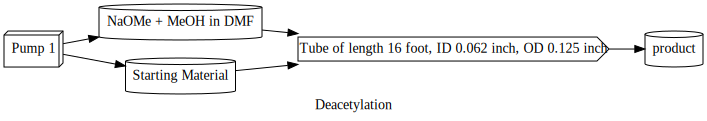

In [7]:
# apparatus 
A = mw.Apparatus("Deacetylation")

A.add(pump_1, reagent_vessel_1, sugar)
A.add(pump_1, reagent_vessel_2, NaOMe)

A.add(reagent_vessel_1, T_1, sugar)
A.add(reagent_vessel_2, T_1, NaOMe)
A.add(T_1, product_vessel, deacetylation)

A.describe()
A.visualize()

### Define Protocol

In [9]:
P = mw.Protocol(A)

switch = timedelta(seconds = 45)

current = timedelta(minutes = 0)

pump_1_reagents = timedelta(minutes = 2)
P.add(pump_1, start = current,
              duration = pump_1_reagents, rate = "1 mL/min")

current += pump_1_reagents + switch

deacetylation = timedelta(minutes = 10) 
P.add(pump_1, start = current, 
              duration = deacetylation, rate = "1 mL/min")

current += deacetylation

print(f'TOTAL TIME: {current}')
P.execute(confirm = True)

TOTAL TIME: 0:12:45


RuntimeError: HarvardSyringePump Pump 1 isn't valid. Got error: '[Errno 2] could not open port /dev/tty.usbmodemD4038611: [Errno 2] No such file or directory: '/dev/tty.usbmodemD4038611''.